In [156]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_plt

from pprint import pprint
from fake_useragent import UserAgent
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory
from scipy.optimize import minimize #import again

# Set some display options Pandas
pd.set_option("display.max_colwidth",None)
pd.set_option("expand_frame_repr",False)


In [157]:
# Define the symbols
symbols = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "META", "PEP", "NFLX", "ADBE",
    # "AVGO", "CSCO", "TXN", "COST", "QCOM", "AMD", "INTC", "PYPL", "AMAT", "SBUX",
    # "HON", "BKNG", "TMUS", "ZM", "ISRG", "MRVL", "WMT", "LRCX", "MDLZ", "SNPS",
    # "GILD", "ILMN", "REGN", "KLAC", "CDNS", "CSX", "ADP", "XEL", "IDXX", "VRTX",
    # "MCHP", "ADI", "WDAY", "MNST", "MAR", "PANW", "ORLY", "ROST", "EXC", "WBA"
]

# Grab the number of Stocks in our Portfolio
number_of_symbols = len(symbols)

# Path to the CSV file
csv_file_path = r"C:\Users\pengx\Python\Portfolio Optimization\portfolio-optimization\data\stock_data.csv"

# If data from stock_data csv does not exist

# Generate a user agent
user_agent = UserAgent().chrome

# Define period as num_months
num_months = 120

# Initialize the PriceHistory Client and Define num_months of backtest data to draw from
price_history_client = PriceHistory(symbols=symbols, user_agent=user_agent, num_months=num_months)
user_agent=UserAgent().chrome

# Grab Data and Dump into a CSV File
price_history_client.price_data_frame.to_csv(csv_file_path, index=False)
# display(price_history_client.price_data_frame)

# Grab the data frame
price_data_frame: pd.DataFrame = price_history_client.price_data_frame

print(price_data_frame.head())


2014-08-22
2024-08-22
AAPL MSFT GOOGL AMZN TSLA NVDA META PEP NFLX ADBE         date   close   volume    open    high     low symbol
0 2024-08-21  565.79  1401708  562.13  566.60  557.91   ADBE
1 2024-08-20  562.25  1219609  564.48  568.18  559.61   ADBE
2 2024-08-19  563.12  1423293  550.59  563.77  550.59   ADBE
3 2024-08-16  553.46  1541726  552.35  554.76  547.80   ADBE
4 2024-08-15  554.16  2182382  545.19  557.22  545.01   ADBE


symbol         AAPL   ADBE     AMZN    GOOGL     META    MSFT     NFLX    NVDA    PEP     TSLA
date                                                                                          
2014-08-22  25.3300  72.04  16.5795  29.6270  74.5700  45.150  68.4557  0.4770  91.60  17.1187
2014-08-25  25.3850  71.82  16.7010  29.5285  75.0200  45.170  68.7043  0.4778  93.19  17.5033
2014-08-26  25.2222  71.53  17.0915  29.4060  75.9601  45.005  68.4800  0.4864  92.60  17.4493
2014-08-27  25.5325  71.55  17.1590  29.1500  74.6300  44.870  67.8143  0.4808  92.23  17.5500
2014-08-28  25.5625  71.37  17.0010  29.0160  73.8550  44.880  67.8871  0.4848  92.58  17.5907


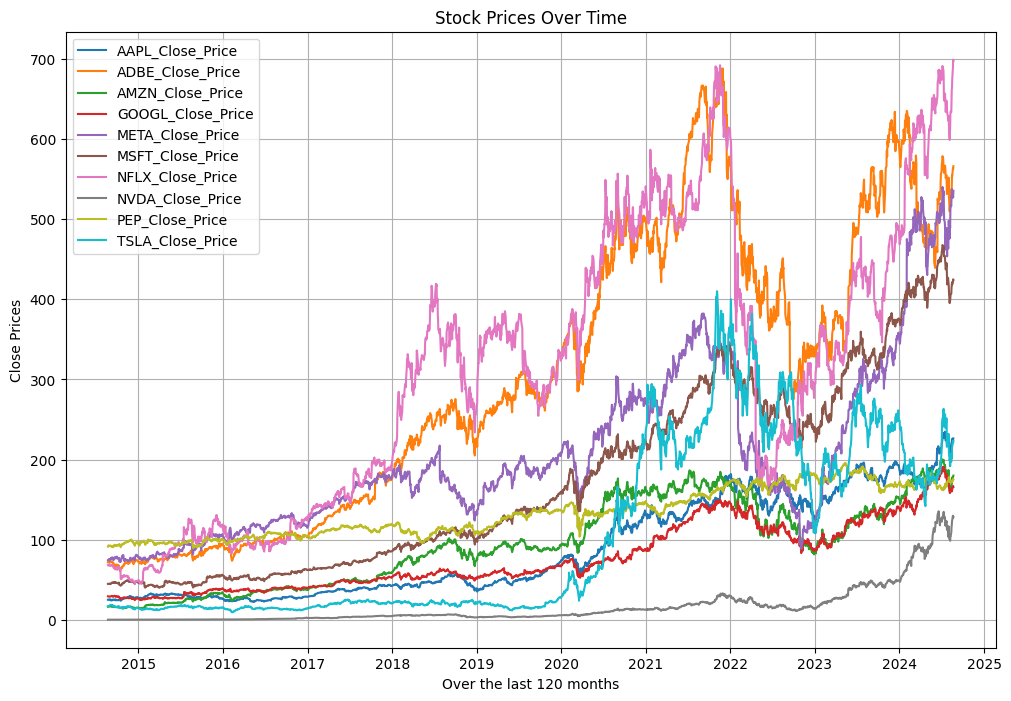

In [158]:
# Selecting date, symbol, close
price_data_frame = price_data_frame[["date", "symbol", "close"]]

# Pivot to have date as index and symbols as columns, and close price as values
price_data_frame = price_data_frame.pivot(
    index="date",
    columns="symbol",
    values="close"
)
print(price_data_frame.head())

# Plotting
plt.figure(figsize=(12, 8))
for symbol in price_data_frame.columns:
    plt.plot(price_data_frame.index, price_data_frame[symbol], label=f'{symbol}_Close_Price')

# Adding labels and title
plt.xlabel(f"Over the last {num_months} months")
plt.ylabel('Close Prices')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

Sharpe Ratio:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio"s Excess Return} \\
\end{align}
$

Return of Portfolio:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

Standard Deviation of Portfolio"s Excess Return:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}
$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [159]:
# Calculate Log Returns
log_return = np.log(1 + price_data_frame.pct_change())

# Generate Random Weights for the number of different stocks in our Portfolio
random_weights = np.array(np.random.random(number_of_symbols))

# Rebalanced sum of weights to 1
rebalanced_weights = random_weights / np.sum(random_weights)

print(rebalanced_weights)

# Calcualte the Expected Returns (annualized at 252 trading days)
exp_ret = np.sum((log_return.mean() * rebalanced_weights) * 252)

# Calculate Expected Volatility (annualized at 252 trading days)
exp_vol = np.sqrt(
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_return.cov() * 252,
            rebalanced_weights
        )
    )
)

# Calculate Sharpe Ratio with 1% risk free rate
sharpe_ratio = (exp_ret - .1) / exp_vol

[0.07466636 0.11754244 0.15182964 0.06346381 0.11654942 0.14490008
 0.07110319 0.05540459 0.14765514 0.05688533]


In [160]:
# Create data frame for weights
weights_df = pd.DataFrame(data={
    "random_weights": random_weights,
    "rebalanced_weights": rebalanced_weights,
})
print("")
print("="*80)
print("PORTFOLIO WEIGHTS")
print("-"*80)
print(weights_df)
print("-"*80)

# Create data frame for weights
metrics_df = pd.DataFrame(data={
    "Expected Portfolio Returns": exp_ret,
    "Expected Portfolio Volatiltiy": exp_vol,
    "Portfolio Sharpe Ratio": sharpe_ratio
}, index=[0])

print("")
print("="*80)
print("PORTFOLIO METRICS")
print("-"*80)
print(metrics_df)
print("-"*80)


PORTFOLIO WEIGHTS
--------------------------------------------------------------------------------
   random_weights  rebalanced_weights
0        0.455303            0.074666
1        0.716755            0.117542
2        0.925833            0.151830
3        0.386992            0.063464
4        0.710700            0.116549
5        0.883577            0.144900
6        0.433576            0.071103
7        0.337848            0.055405
8        0.900377            0.147655
9        0.346878            0.056885
--------------------------------------------------------------------------------

PORTFOLIO METRICS
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatiltiy  Portfolio Sharpe Ratio
0                    0.215276                       0.241992                0.476365
--------------------------------------------------------------------------------


In [161]:
# Define quantity of simulations
num_of_portfolios = 1000

# Define risk free rate
rfr = 0.05

# Prep Weight Array of Numpy Zeros to store simulation results
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep Returns Array of Numpy Zeros to store simulation results
ret_arr = np.zeros((num_of_portfolios))

# Prep Volatility Array of Numpy Zeros to store simulation resultsps
vol_arr = np.zeros((num_of_portfolios))

# Prep Sharpe Ratio Array of Numpy Zeros to store simulation results
sharpe_arr = np.zeros((num_of_portfolios))

# Begin simulation
for ind in range(num_of_portfolios):

    # Generate random weights on each iteration; Sum of weights needs to be equal to 1
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights to the `weights_array`
    all_weights[ind, :] = weights

    # Calculate Expected Log Returns (annualized)
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate Volatility and add to `vol_arr`
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    ) 

    # Calculate Sharpe Ratio
    sharpe_arr[ind] = (ret_arr[ind] - rfr) / vol_arr[ind]

# Combine arrays
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a dataframe from the master array
simulations_df = pd.DataFrame(data=simulations_data).T

# Add column Names
simulations_df.columns = [
    "Returns",
    "Volatility",
    "Sharpe Ratio",
    "Portfolio Weights"
]

# Check data types of simulations_df
simulations_df = simulations_df

# Print out simulation dataframe
print("")
print("="*80)
print("Simulation Result")
print("-"*80)
print(simulations_df.head())
print("-"*80)



Simulation Result
--------------------------------------------------------------------------------
    Returns Volatility Sharpe Ratio                                                                                                                                                                                                    Portfolio Weights
0  0.250667    0.25643     0.782542   [0.09024163944383393, 0.04418539020123236, 0.06776434615497852, 0.058129882653495064, 0.02379089589583857, 0.13383357141940028, 0.06358114472470343, 0.1664550288310409, 0.19722323824186236, 0.15479486243361443]
1  0.217197   0.267688     0.624599     [0.07647808099134176, 0.10751551432749117, 0.15590558372048152, 0.14351707819391882, 0.11455232261728807, 0.013262251235041581, 0.1612017283672232, 0.02454478911850385, 0.06713239022610619, 0.135890261202604]
2  0.222889   0.242515     0.712899  [0.045402171728556075, 0.022762733308470624, 0.03170166681890949, 0.17843201925010832, 0.19432579425195423, 0.124164

In [162]:
# Find Max Sharpe Ratio
max_sharpe_ratio = simulations_df.loc[simulations_df["Sharpe Ratio"].idxmax()]

# Find Min Volatility
min_volatility = simulations_df.loc[simulations_df["Volatility"].idxmin()]

print("")
print("="*80)
print("Max Sharpe Ratio")
print("-"*80)
print(max_sharpe_ratio)
print("-"*80)

print("")
print("="*80)
print("Min Volatility")
print("-"*80)
print(min_volatility)
print("-"*80)


Max Sharpe Ratio
--------------------------------------------------------------------------------
Returns                                                                                                                                                                                                                          0.290902
Volatility                                                                                                                                                                                                                       0.275733
Sharpe Ratio                                                                                                                                                                                                                     0.873679
Portfolio Weights    [0.09739281219345249, 0.12468585498676328, 0.027616829904631043, 0.2034371327912865, 0.033577815596253516, 0.08843033857526152, 0.009773752871364356, 0.2774560110302227, 0.091905

In [163]:
# %matplotlib inline

# # Plot data on Scatter Plot, Portfolio Returns vs Risk
# plt.scatter(
#     y=simulations_df["Returns"],
#     x=simulations_df["Volatility"],
#     c=simulations_df["Sharpe Ratio"],
#     cmap="YlGnBu"
# )

# # Add Title, Colorbar, x-axis, y-axis labels
# plt.title("Portfolio Returns v. Risk (Monte Carlo)")
# plt.colorbar(label="Sharpe Ratio")
# plt.xlabel("Standard Deviation / Risk")
# plt.ylabel("Returns")

# # Plot Max Sharpe Ratio using using a red star
# plt.scatter(
#     max_sharpe_ratio[1],
#     max_sharpe_ratio[0],
#     marker=(4,1,0),
#     color="r",
#     s=600
# )

# # Plot Min Volatility using using a blue star
# plt.scatter(
#     min_volatility[1],
#     min_volatility[0],
#     marker=(4,1,0),
#     color="b",
#     s=600
# )

# # Show Plot
# plt.show()

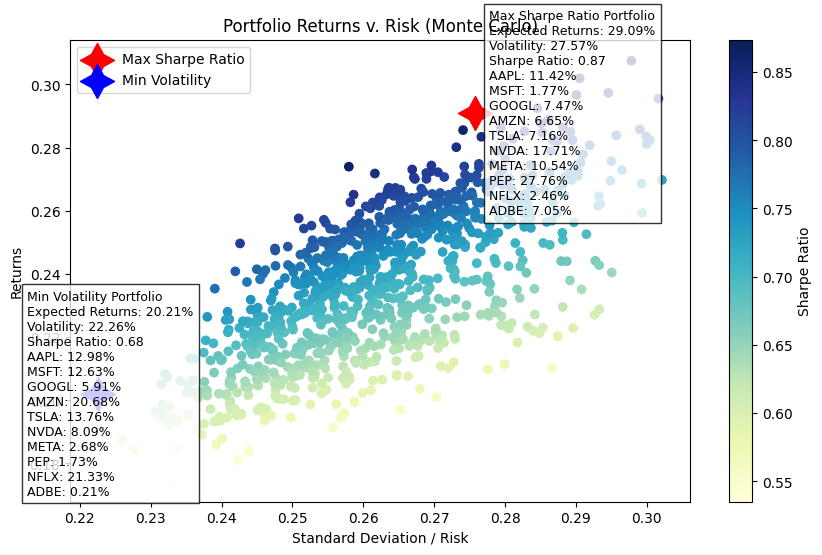

In [164]:
# Prepare text for annotation with additional metrics
max_sharpe_text = (
    f"Max Sharpe Ratio Portfolio\n"
    f"Expected Returns: {max_sharpe_ratio['Returns']:.2%}\n"
    f"Volatility: {max_sharpe_ratio['Volatility']:.2%}\n"
    f"Sharpe Ratio: {max_sharpe_ratio['Sharpe Ratio']:.2f}\n"
    + "\n".join([f"{symbol}: {weight:.2%}" for symbol, weight in zip(symbols, max_sharpe_weights)])
)

min_volatility_text = (
    f"Min Volatility Portfolio\n"
    f"Expected Returns: {min_volatility['Returns']:.2%}\n"
    f"Volatility: {min_volatility['Volatility']:.2%}\n"
    f"Sharpe Ratio: {min_volatility['Sharpe Ratio']:.2f}\n"
    + "\n".join([f"{symbol}: {weight:.2%}" for symbol, weight in zip(symbols, min_volatility_weights)])
)

# Plot data on Scatter Plot, Portfolio Returns vs Risk
plt.figure(figsize=(10, 6))
plt.scatter(
    y=simulations_df["Returns"],
    x=simulations_df["Volatility"],
    c=simulations_df["Sharpe Ratio"],
    cmap="YlGnBu"
)

# Add Title, Colorbar, x-axis, y-axis labels
plt.title("Portfolio Returns v. Risk (Monte Carlo)")
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Standard Deviation / Risk")
plt.ylabel("Returns")

# Plot Max Sharpe Ratio using a red star
plt.scatter(
    max_sharpe_ratio["Volatility"],
    max_sharpe_ratio["Returns"],
    marker=(4,1,0),
    color="r",
    s=600,
    label="Max Sharpe Ratio"
)

# Plot Min Volatility using a blue star
plt.scatter(
    min_volatility["Volatility"],
    min_volatility["Returns"],
    marker=(4,1,0),
    color="b",
    s=600,
    label="Min Volatility"
)

# Annotate the Max Sharpe Ratio Portfolio
plt.text(
    max_sharpe_ratio["Volatility"] + 0.002,  # Adjusting position to the right
    max_sharpe_ratio["Returns"],
    max_sharpe_text,
    fontsize=9,
    verticalalignment='center',
    bbox=dict(facecolor='white', alpha=0.8)
)

# Annotate the Min Volatility Portfolio
plt.text(
    min_volatility["Volatility"] - 0.01,  # Adjusting position to the left
    min_volatility["Returns"],
    min_volatility_text,
    fontsize=9,
    verticalalignment='center',
    bbox=dict(facecolor='white', alpha=0.8)
)

# Show Plot
plt.legend(loc='upper left')
plt.show()
